# Introdução a previsão de Séries Temporais

> ECOP 2024  
> Minicurso: Data Science com Python - Introdução a Previsão de Séries Temporais  
> Ministrante: Gabriel Caldas

## Importação das dependências principais

In [1]:
import pandas as pd                 # Para leitura, manipulação e processamento dos dados
import numpy as np                  # Para realização de operações em arrays
import matplotlib.pyplot as plt     # Para visualização dos dados

import warnings                     # Para controlar os avisos de log

In [2]:
warnings.filterwarnings('ignore')

## Leitura dos dados

Todos os dados utilizados neste minicurso estão disponíveis [neste repositório](https://github.com/gabrielgcbs/ecop-timeseries-forecasting-datasets)

Nesta primeira parte, vamos utilizar um dataset que contém a série histórica de **vendas** de uma grande varejista brasileira.

A função `read_csv()`, do pandas, pode ser usada para ler arquivos *csv*. Para uma lista completa de formatos aceitos pelo pandas, [veja aqui](https://pandas.pydata.org/docs/reference/io.html).

In [3]:
df = pd.read_csv('./data/retail_sales.csv')

In [4]:
df.head()

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


O *dataset* é composto por 4 colunas:
- data: pontos no tempo no qual cada amostra ocorreu
- venda: quantidade de unidades vendidas
- estoque: quantidade de unidades em estoque
- preco: preço de cada unidade

Nosso *target* é a coluna `venda`

## Pré-processamento dos dados

Nessa etapa é feita a filtragem e limpeza dos dados, onde os dados são selecionados e valores faltantes, incorretos e com ruído são tratados.

Para entender um pouco melhor sobre a estrutura geral dos dados, podemos usar o método `info()`

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     937 non-null    object 
 1   venda    937 non-null    int64  
 2   estoque  937 non-null    int64  
 3   preco    937 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 29.4+ KB


In [6]:
df.dtypes

data        object
venda        int64
estoque      int64
preco      float64
dtype: object

A coluna *data* está como *object*. Podemos transformá-la no tipo `datetime`

In [57]:
df_processed = df.copy()        #  Criando uma cópia do dataset
df_processed['data'] = pd.to_datetime(df_processed['data'])

Podemos checar a quantidade de vazios nos dados de várias formas

In [58]:
df_processed.isna().sum()

data       0
venda      0
estoque    0
preco      0
dtype: int64

In [59]:
df_processed.isnull().sum()

data       0
venda      0
estoque    0
preco      0
dtype: int64

Não há dados vazios, porém a série temporal está completa?

Para descobrir isso, precisamos saber se todos os pontos dentro do intervalo dos dados existem, ou se falta alguma data.

Os dados estão na frequência diária, logo, devemos checar se todos os dias estão presentes.

In [60]:
missing_days = (
    (df_processed['data'].max() - df_processed['data'].min() + pd.Timedelta(days=1)) - 
    pd.Timedelta(days=len(df_processed['data']))
)
print(f'Faltam {missing_days}')

Faltam 6 days 00:00:00


Há 6 dias faltantes. Precisamos preencher a série.

No entanto, antes de aplicar qualquer transformação nos dados, é importante realizar a separação dos dados em treino e teste, pois isso evita o ***Data Leakage*** (Vazamento de dados).

Todas as transformações feitas nos dados de treinamento, também devem ser feitas nos de teste.

In [145]:
# Separar os dados em 80% para treino, 20% para teste

train_size = int(np.round(len(df_processed)*0.8))
train = df_processed.iloc[:train_size]
test = df_processed.iloc[train_size:]

train.shape, test.shape

((750, 4), (187, 4))



O método `resample()` reamostra uma base de dados dada uma frequência específica.

Para que o dataset não fique com valores vazios (nas datas que serão adicionadas), vamos utilizar o método *forward fill* (`ffill()`) para preencher os vazios.

In [146]:
train = train.resample(rule='d', on='data').mean().ffill()
test = test.resample(rule='d', on='data').mean().ffill()

In [147]:
train.head()

,venda,estoque,preco
data,,,
2014-01-01,0.0,4972.0,1.29
2014-01-02,70.0,4902.0,1.29
2014-01-03,59.0,4843.0,1.29
2014-01-04,93.0,4750.0,1.29
2014-01-05,96.0,4654.0,1.29


A coluna *data* se tornou o *index* do *dataframe*.

Para mais informações sobre o método `resample()`, [acesse](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html#pandas.DataFrame.resample).

Vamos checar se há algum valor vazio após a reamostragem.

In [148]:
train.isna().sum()

venda      0
estoque    0
preco      0
dtype: int64

In [149]:
test.isna().sum()

venda      0
estoque    0
preco      0
dtype: int64

Os tipos de dados estão como float64

In [150]:
train.dtypes

venda      float64
estoque    float64
preco      float64
dtype: object

Quando se trabalha com datasets muito grandes (o que não é o caso), uma boa prática é ajustar os tipos de dados. Isso pode reduzir bastante o espaço ocupado pelo dataset na memória RAM.

Para fins didáticos, vamos alterar os tipos de dados.

In [151]:
train['venda'] = train['venda'].astype('int32')       # O número de vendas sempre será inteiro
train['estoque'] = train['estoque'].astype('int32')   # O número de itens em estoque sempre será inteiro
train['preco'] = train['preco'].astype('float16')     # O preço é um pequeno valor real
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2014-01-01 to 2016-01-26
Freq: D
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   venda    756 non-null    int32  
 1   estoque  756 non-null    int32  
 2   preco    756 non-null    float16
dtypes: float16(1), int32(2)
memory usage: 13.3 KB


In [152]:
test['venda'] = test['venda'].astype('int32')       # O número de vendas sempre será inteiro
test['estoque'] = test['estoque'].astype('int32')   # O número de itens em estoque sempre será inteiro
test['preco'] = test['preco'].astype('float16')     # O preço é um pequeno valor real

Um método útil para entender o comportamento geral dos dados é o `describe()`. Ele permite se ter uma ideia se há *outliers*, grande variação nos dados, etc.

In [153]:
train.describe()

,venda,estoque,preco
count,756.000000,756.000000,756.000000
mean,78.574074,1537.972222,1.421875
std,73.272121,1425.725323,0.417725
min,0.000000,0.000000,0.000000
25%,20.000000,701.750000,1.290039
50%,65.000000,1186.000000,1.290039
75%,111.000000,1930.750000,1.490234
max,542.000000,7228.000000,2.980469


Podemos ver que a média e desvio padrão das colunas venda e estoque estão bem próximos, indicando que possivelmente há *outliers*.

Além disso, há preços com o valor 0. Vamos checar se isso faz sentido.

In [154]:
train[train['preco'] == 0]

,venda,estoque,preco
data,,,
2014-06-12,0,2136,0.0
2014-07-15,0,794,0.0
2014-07-16,0,794,0.0
2014-07-17,0,794,0.0
2014-07-18,0,794,0.0
2014-08-28,0,1186,0.0
2015-05-09,0,15,0.0
2016-01-09,0,584,0.0
2016-01-17,0,107,0.0


As amostras onde o preço está como 0, são aquelas onde não houve venda. Nesse caso, é plausível entender que faz sentido, portanto, podemos manter os dados como estão.

> Obs.: O ideal é realizar o tratamento os *outliers*. Porém, por simplificação e limitação de tempo, vamos manter os *outliers*.

## Análise de séries temporais

### Exploração dos dados (*Exploratory Data Analysis* - EDA)

Neste passo, os dados são explorados, com o objetivo de entender seu comportamento e gerar *insights* que podem ser úteis para a construção dos modelos.

Vamos checar qual o intervalo dos dados

In [155]:
train.index.min(), train.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2016-01-26 00:00:00'))

In [156]:
test.index.min(), test.index.max()

(Timestamp('2016-01-27 00:00:00'), Timestamp('2016-07-31 00:00:00'))

#### Visualização das séries históricas

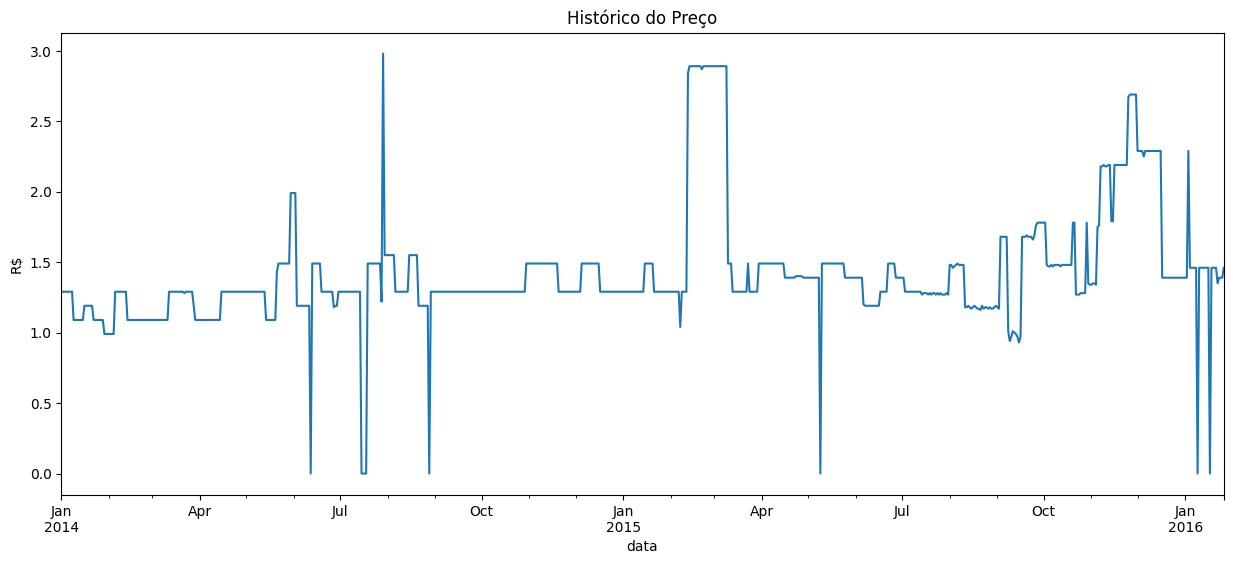

In [157]:
train['preco'].plot(kind='line', figsize=(15, 6), title='Histórico do Preço')
plt.ylabel('R$')
plt.show()

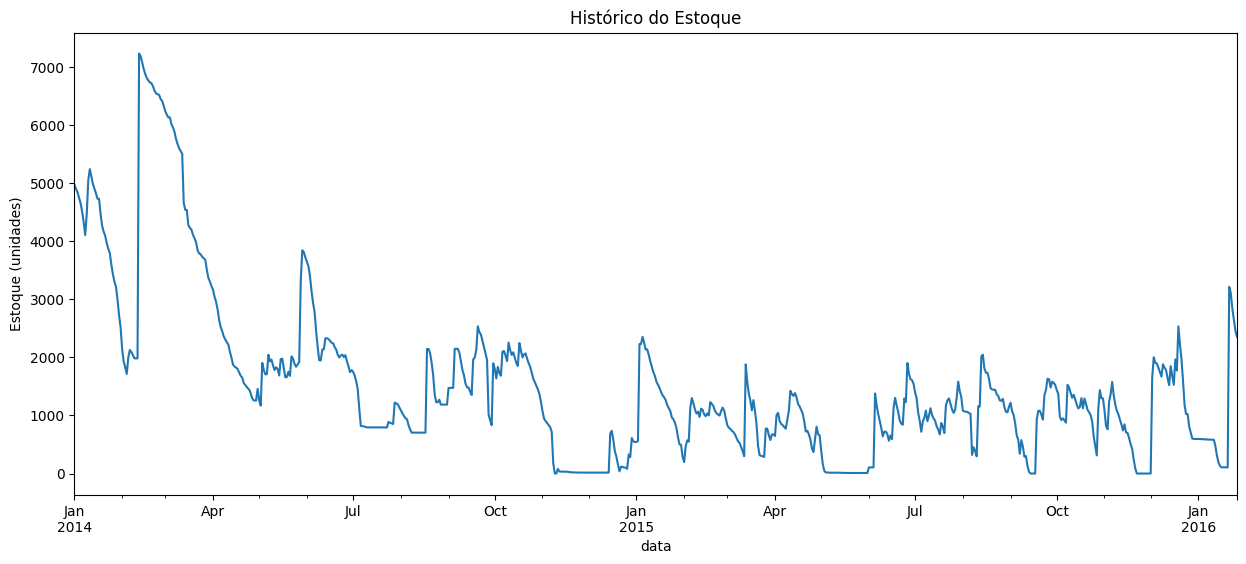

In [158]:
train['estoque'].plot(kind='line', figsize=(15, 6), title='Histórico do Estoque')
plt.ylabel('Estoque (unidades)')
plt.show()

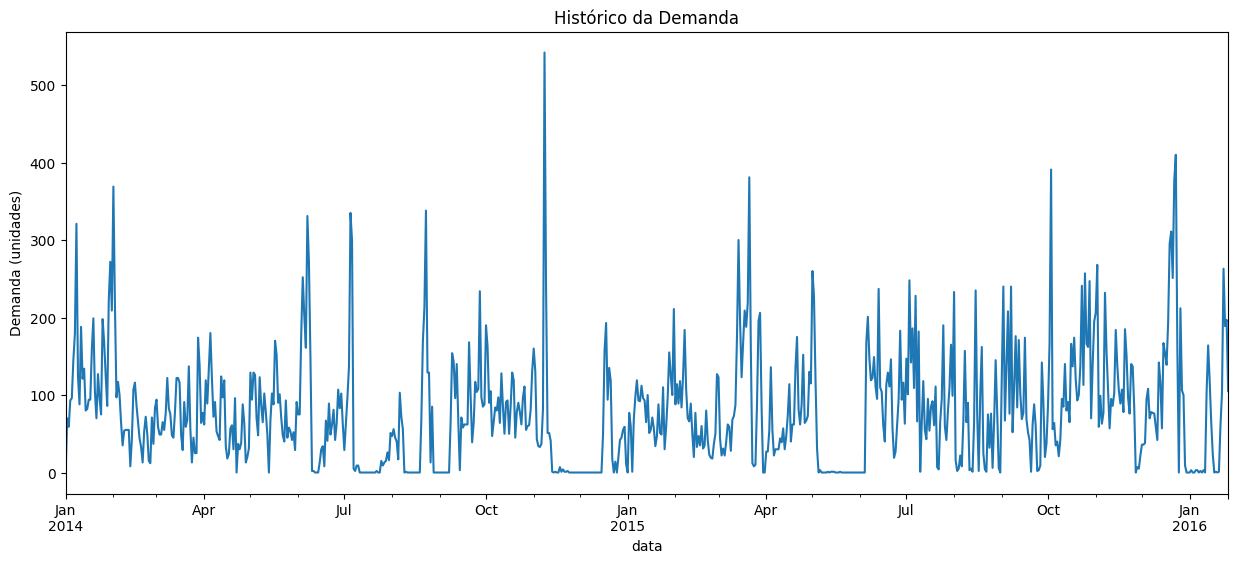

In [159]:
train['venda'].plot(kind='line', figsize=(15, 6), title='Histórico da Demanda')
plt.ylabel('Demanda (unidades)')
plt.show()

#### Autocorrelação

Um conceito importante de Séries Temporais é a *lag*. Nesse contexto, *Lags* são intervalos de tempo entre um evento e outro.

Por exemplo, se no dia 1 a quantidade de vendas foi 10 e no dia 2 a quantidade de vendas foi 15, a *lag 1* no dia 2 seria a quantidade referente as vendas do dia 1, ou seja, 10.

A autocorrelação mede o coeficiente de correlação entre uma variável e ela mesma, dado um número variável de *lags*. Podemos visualizar essa informação através da função `plot_acf` (*plot autocorrelation function*)

In [160]:
from statsmodels.graphics.tsaplots import plot_acf

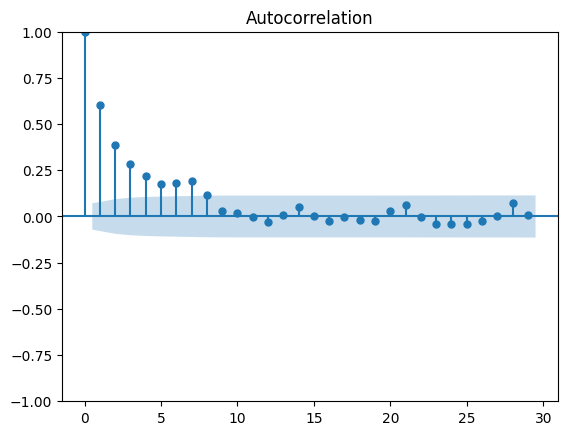

In [161]:
plot_acf(train['venda'])
plt.show()

Como interpretar?

- Valores positivos: relação positiva entre o valor atual e passado na *lag* k 
- Valores negativos: relação negativa entre o valor atual e passado na *lag* k
- Limites de significância: Valores fora desse intervalo são significantes.

Através do plot, podemos ver que até a ***lag* 7** é significativa. Após ela, não há autocorrelação significativa.

### Tendência

Séries temporais possuem vários componentes estatísticos que podem ser avaliados. A tendência é a direção geral na qual a série está se movendo ao longo do tempo. Ela permite identificar mudanças de longo prazo nos dados.

Entender a tendência pode ser útil para ajudar a tomar decisões estratégicas e a modelar os dados, principalmente quando usamos modelos estatísticos.

Uma forma de identificar a tendência de uma série temporal, é usando a **Média Móvel**, que é uma média calculada com base em uma janela de tempo.

> Por exemplo, a média móvel com uma janela de tamanho 3 em um determinado ponto no tempo é a média do ponto atual e dos dois pontos anteriores.

In [162]:
moving_avg = train['venda'].rolling(
    window=30,     # 1 mês
    center=True,    # define a média como sendo no centro da janela
    min_periods=15 # metade da janela
).mean()

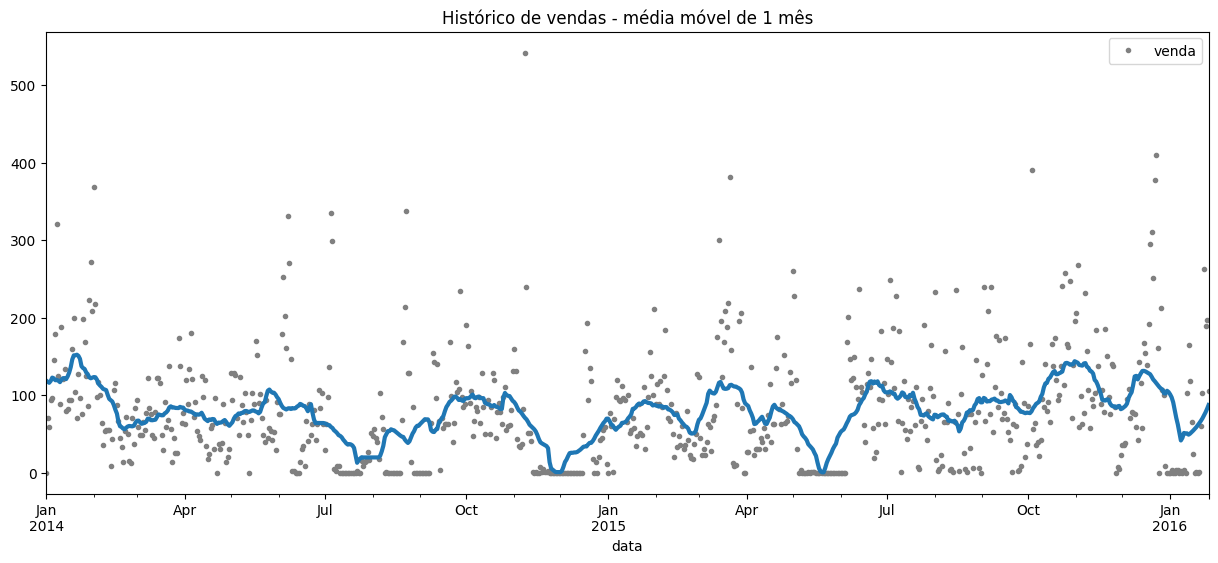

In [163]:
ax = train['venda'].plot(style=".", color="0.5", legend=True)
moving_avg.plot(
    ax=ax, linewidth=3, title="Histórico de vendas - média móvel de 1 mês", legend=False, figsize=(15, 6)
);

Podemos perceber que não há uma tendência clara nos dados.

### Sazonalidade

Sazonalidade são padrões recorrentes nas séries temporais, e podem ocorrer por uma série de fatores, como por exemplo, feriados, estações do ano, etc.

Quando se trata da previsão de séries temporais, especialmente de demanda, é importante detectar a sazonalidade para melhor entender os padrões dos dados.

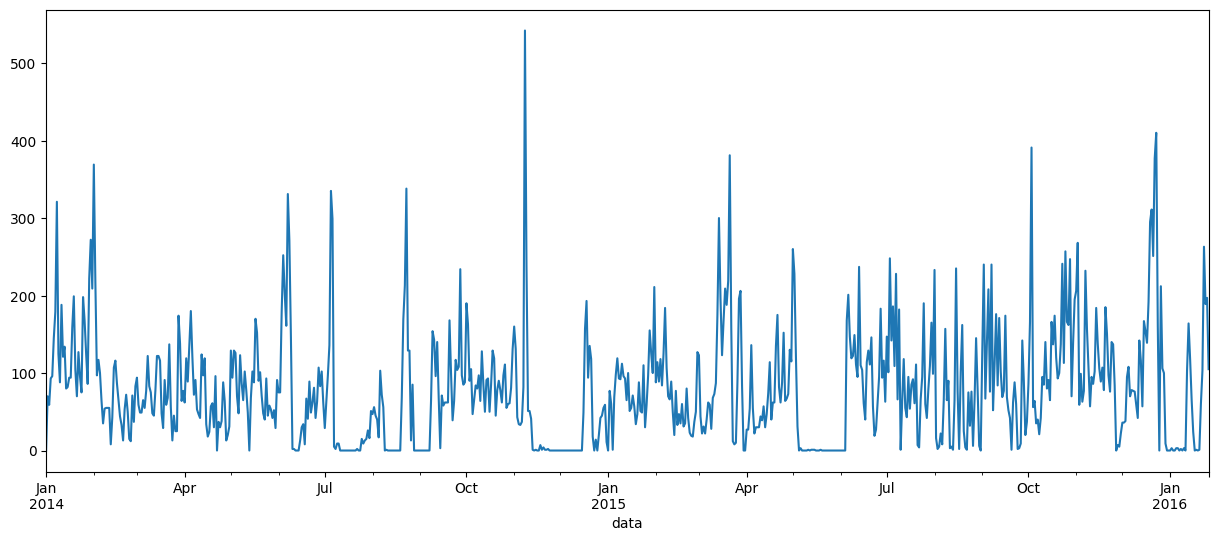

In [164]:
train['venda'].plot(figsize=(15, 6))
plt.show()

Através da visualização da série temporal de vendas, podemos perceber uma leve sazonalidade, que aparentemente é menor que um mês, ou seja, semanal. O que vai de encontro com a informação que encontramos no plot de autocorrelação (*lag 7*)

Vamos confirmar isso utilizando a função `seasonal_decompose()`, que decompõe a série temporal em 3 componentes: *tendência*, *sazonalidade* e *resíduo*.

O componente residual mostra os pontos que não foram capturados pela tendência nem sazonalidade. Ou seja, indica o **ruído** que há nos dados.

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

Vamos utilizar o período de 7 dias, e considerar que a decomposição da série é do tipo aditiva, ou seja, a sazonalidade da série é relativamente constante no tempo.

Outra opção seria um modelo de decomposição multiplicativo, que considera que a variação da sazonalidade aumenta com o tempo. O que não é o caso.

1. Aditivo: $ x=trend+seasonal+resid $  
2. Multiplicativo: $ x=trend\cdot seasonal\cdot resid $

In [86]:
decomposition = seasonal_decompose(train['venda'], model="additive", period=7)

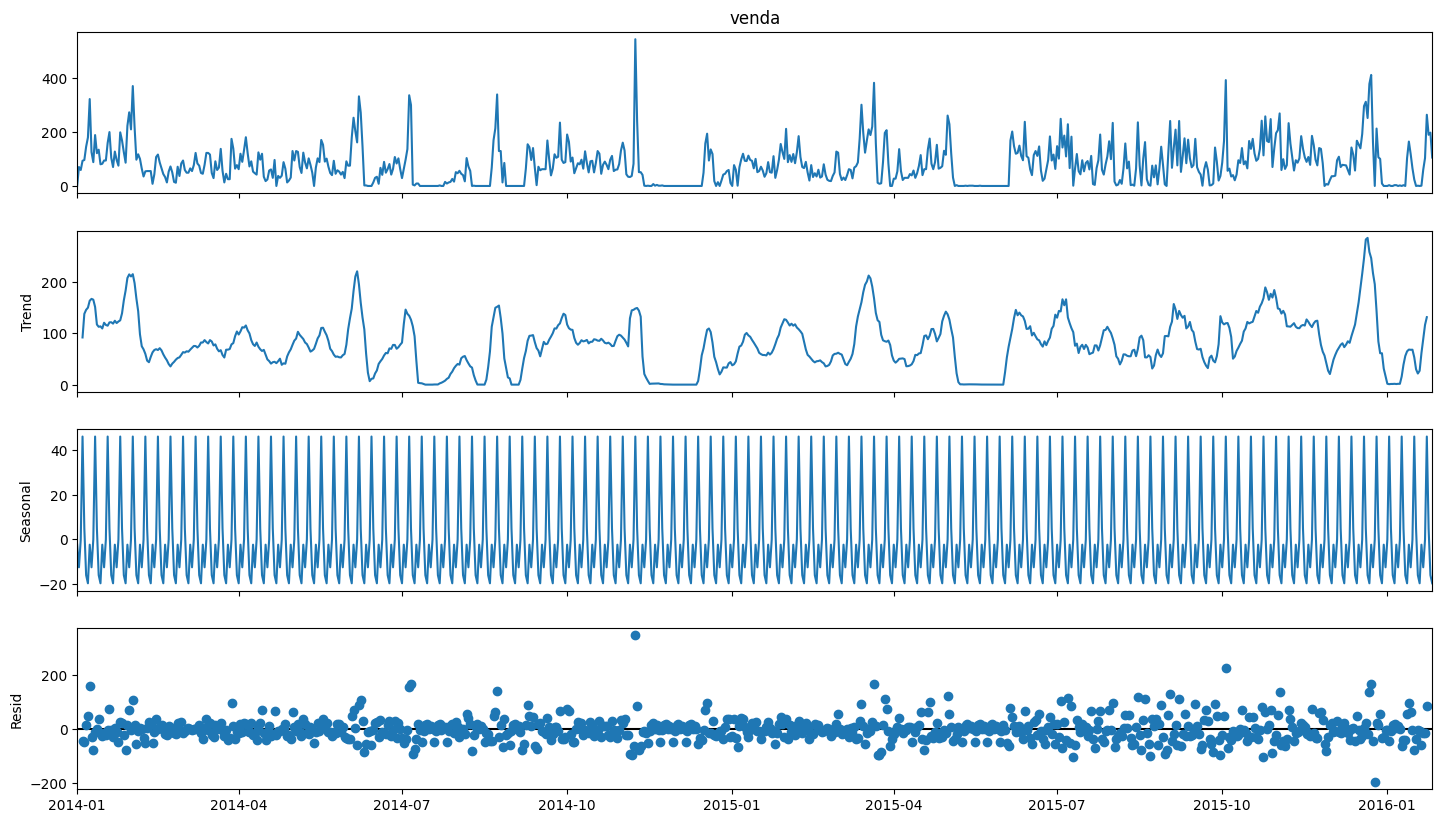

In [87]:
# Extrai os componentes de tendência, sazonalidade e resíduo
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

fig = decomposition.plot()
fig.set_size_inches((16, 9))        # determinar tamanho do plot
plt.show()

Através do plot acima, podemos perceber que realmente não há tendência nos dados, que há sazonalidade semanal e bastante ruído.

Uma das formas de lidar com a sazonalidade é removendo ela da série temporal e a tornando **Estacionária**.

> Isto é, a média e variância são consistentes durante o tempo.

No entanto, iremos utilizar modelos de Machine Learning, mais especificamente modelos baseados em árvores, que são capazes de detectar a sazonalidade. Sem contar que a natureza do problema (vendas) tem influência da sazonalidade. Desse modo, podemos manter essa informação nos dados.

Portanto, podemos prosseguir com os dados.

## Feature Engineering

As séries temporais costumam ter muitas informações intrínsecas nos dados, que não estão explícitas.

O processo de criação de novas *features*, sejam elas a partir dos próprios dados ou de dados externos, é chamado de *feature engineering*.

In [168]:
train_feat = train[['estoque', 'preco', 'venda']]      # Selecionando as features relevantes
test_feat = test[['estoque', 'preco', 'venda']]

Através do plot de autocorrelação, chegamos a conclusão que as *lags* até *lag 7* são relevantes. Vamos criar essa *feature* com base no *target*

In [169]:
lags = np.arange(1, 8)      # 7 lags
for lag in lags:
    train_feat[f'venda_lag_{lag}'] = train_feat['venda'].shift(lag)
    test_feat[f'venda_lag_{lag}'] = test_feat['venda'].shift(lag)

train_feat.head(10)

,estoque,preco,venda,venda_lag_1,venda_lag_2,venda_lag_3,venda_lag_4,venda_lag_5,venda_lag_6,venda_lag_7
data,,,,,,,,,,
2014-01-01,4972,1.290039,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,4902,1.290039,70,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,4843,1.290039,59,70.0,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-04,4750,1.290039,93,59.0,70.0,0.0,NaN,NaN,NaN,NaN
2014-01-05,4654,1.290039,96,93.0,59.0,70.0,0.0,NaN,NaN,NaN
2014-01-06,4509,1.290039,145,96.0,93.0,59.0,70.0,0.0,NaN,NaN
2014-01-07,4329,1.290039,179,145.0,96.0,93.0,59.0,70.0,0.0,NaN
2014-01-08,4104,1.290039,321,179.0,145.0,96.0,93.0,59.0,70.0,0.0
2014-01-09,4459,1.089844,125,321.0,179.0,145.0,96.0,93.0,59.0,70.0


Podemos criar outras *features* além das *lags*.

Há várias informações que podemos extrair das séries temporais, que podem ser relevantes ou não para o modelo.

O Pandas tem várias funções *built-ins* que podem ser úteis, como o dia da semana, dia do mês, semana do ano, etc.
Vamos criar a *feature* do dia da semana.

In [173]:
train_feat['day'] = train_feat.index.day_of_week    # o atributo day_of_week do pandas considera que a semana inicia na segunda. Segunda: 0, Domingo: 6
test_feat['day'] = test_feat.index.day_of_week
train_feat.head()

,estoque,preco,venda,venda_lag_1,venda_lag_2,venda_lag_3,venda_lag_4,venda_lag_5,venda_lag_6,venda_lag_7,day
data,,,,,,,,,,,
2014-01-01,4972,1.290039,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2014-01-02,4902,1.290039,70,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3
2014-01-03,4843,1.290039,59,70.0,0.0,NaN,NaN,NaN,NaN,NaN,4
2014-01-04,4750,1.290039,93,59.0,70.0,0.0,NaN,NaN,NaN,NaN,5
2014-01-05,4654,1.290039,96,93.0,59.0,70.0,0.0,NaN,NaN,NaN,6


Além disso, há um tipo de *feature* criada a partir de um método chamado ***cycle encoding***.

Esse método permite informar ao modelo quando alguma informação ocorre de forma cíclica. No caso, como estamos tratando de séries temporais, ao invés de representar os meses do ano ou a semana do ano diretamente como números inteiros, podemos aplicar transformações trigonométricas para torná-los valores cíclicos.

<center>

$ x_{sin}=sin(\frac{2\pi x}{max(x)}) $ 

$ x_{cos}=cos(\frac{2\pi x}{max(x)}) $

</center>

In [174]:
# Treino
train_feat['sin_week'] = np.sin(2 * np.pi * train_feat.index.isocalendar().week / 12)
train_feat['cos_week'] = np.cos(2 * np.pi * train_feat.index.isocalendar().week / 12)
train_feat['sin_month'] = np.sin(2 * np.pi * train_feat.index.month / 12)
train_feat['cos_month'] = np.cos(2 * np.pi * train_feat.index.month / 12)

# Teste
test_feat['sin_week'] = np.sin(2 * np.pi * test_feat.index.isocalendar().week / 12)
test_feat['cos_week'] = np.cos(2 * np.pi * test_feat.index.isocalendar().week / 12)
test_feat['sin_month'] = np.sin(2 * np.pi * test_feat.index.month / 12)
test_feat['cos_month'] = np.cos(2 * np.pi * test_feat.index.month / 12)

train_feat.head()

,estoque,preco,venda,venda_lag_1,venda_lag_2,venda_lag_3,venda_lag_4,venda_lag_5,venda_lag_6,venda_lag_7,day,sin_week,cos_week,sin_month,cos_month
data,,,,,,,,,,,,,,,
2014-01-01,4972,1.290039,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0.5,0.866025,0.5,0.866025
2014-01-02,4902,1.290039,70,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3,0.5,0.866025,0.5,0.866025
2014-01-03,4843,1.290039,59,70.0,0.0,NaN,NaN,NaN,NaN,NaN,4,0.5,0.866025,0.5,0.866025
2014-01-04,4750,1.290039,93,59.0,70.0,0.0,NaN,NaN,NaN,NaN,5,0.5,0.866025,0.5,0.866025
2014-01-05,4654,1.290039,96,93.0,59.0,70.0,0.0,NaN,NaN,NaN,6,0.5,0.866025,0.5,0.866025


## *Backtesting* com modelos de *Machine Learning* 

### LightGBM

In [204]:
from sklearn.metrics import mean_squared_error

In [132]:
from lightgbm import LGBMRegressor

Separando os dados em X e y

In [178]:
X_train = train_feat.drop(columns='venda')
y_train = train_feat['venda']
X_test = test_feat.drop(columns='venda')
y_test = test_feat['venda']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((756, 14), (756,), (187, 14), (187,))

In [212]:
lgbm_model = LGBMRegressor(num_leaves=10, learning_rate=0.1, random_state=42)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1344
[LightGBM] [Info] Number of data points in the train set: 756, number of used features: 14
[LightGBM] [Info] Start training from score 78.574074


LGBMRegressor(num_leaves=10, random_state=42)

In [213]:
lgbm_pred = lgbm_model.predict(X_test)
lgbm_pred = pd.Series(lgbm_pred, index=y_test.index)

#### Avaliação do modelo

# Treino
RMSE: 28.70994698254903
# Teste
RMSE: 73.88171840192967


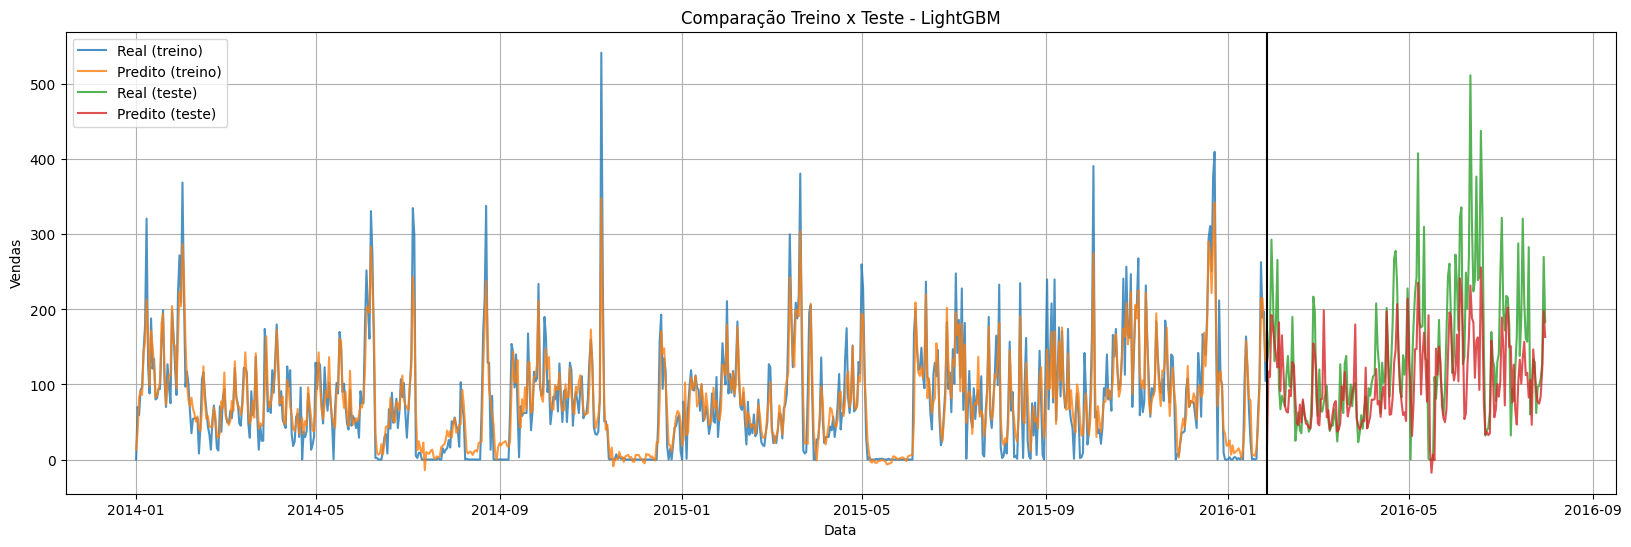

In [230]:
# Cálculo do RMSE - Root Mean Squared Error
print('# Treino')
lgbm_pred_train = pd.Series(lgbm_model.predict(X_train), index=y_train.index)
rmse_train = mean_squared_error(y_train, lgbm_pred_train, squared=False)
print(f"RMSE: {rmse_train}")

print('# Teste')
rmse_test = mean_squared_error(y_test, lgbm_pred, squared=False)
print(f"RMSE: {rmse_test}")


plt.figure(figsize=(20, 6))
plt.plot(y_train, label="Real (treino)", alpha=0.8)
plt.plot(lgbm_pred_train, label="Predito (treino)", alpha=0.8)
plt.plot(y_test, label="Real (teste)", alpha=0.8)
plt.plot(lgbm_pred, label="Predito (teste)", alpha=0.8)

plt.axvline(y_test.index[0], color='#000000')

plt.xlabel("Data")
plt.ylabel("Vendas")
plt.title("Comparação Treino x Teste - LightGBM")

plt.legend()
plt.grid(True)
plt.show()

In [259]:
pd.DataFrame(lgbm_model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values(by='importance', ascending=False)

,importance
venda_lag_1,133
venda_lag_2,88
day,86
estoque,83
venda_lag_7,80
venda_lag_5,78
venda_lag_6,70
venda_lag_3,62
venda_lag_4,56
sin_week,45


#### XGBoost

In [249]:
from xgboost import XGBRegressor

# Definir e treinar o XGBoost
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

# Realizar predições
xgb_pred = xgb_model.predict(X_test)
xgb_pred = pd.Series(xgb_pred, index=y_test.index)


# # Evaluate model performance
# rmse = mean_squared_error(y_test.values, xgb_pred, squared=False)
# print(f"Root Mean squared error on test set: {rmse}")

# # (Optional) Visualize predictions vs. actual values
# plt.plot(y_test.values, label="Actual")
# plt.plot(y_pred, label="Predicted")
# plt.legend()
# plt.show()


#### Avaliação do modelo

# Treino
RMSE: 24.100195954230102
# Teste
RMSE: 77.04822446042073


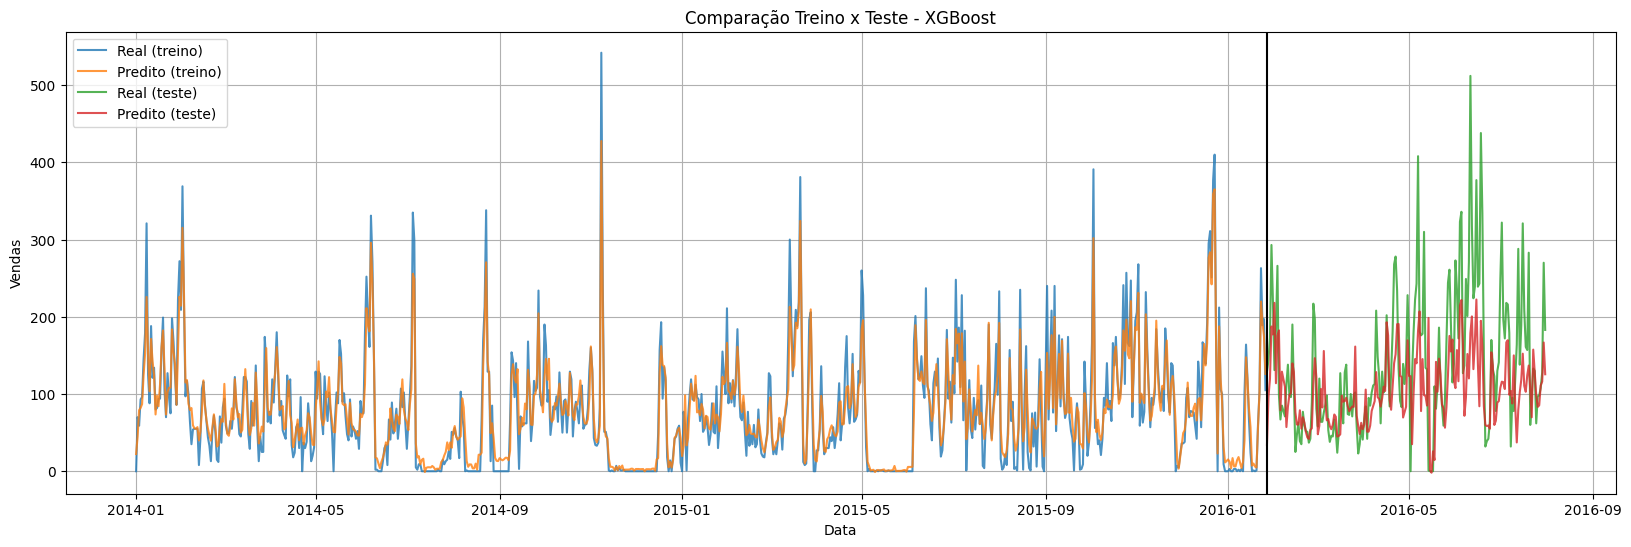

In [250]:
# Cálculo do RMSE - Root Mean Squared Error
print('# Treino')
xgb_pred_train = pd.Series(xgb_model.predict(X_train), index=y_train.index)
rmse_train = mean_squared_error(y_train, xgb_pred_train, squared=False)
print(f"RMSE: {rmse_train}")

print('# Teste')
rmse_test = mean_squared_error(y_test, xgb_pred, squared=False)
print(f"RMSE: {rmse_test}")


plt.figure(figsize=(20, 6))
plt.plot(y_train, label="Real (treino)", alpha=0.8)
plt.plot(xgb_pred_train, label="Predito (treino)", alpha=0.8)
plt.plot(y_test, label="Real (teste)", alpha=0.8)
plt.plot(xgb_pred, label="Predito (teste)", alpha=0.8)

plt.axvline(y_test.index[0], color='#000000')

plt.xlabel("Data")
plt.ylabel("Vendas")
plt.title("Comparação Treino x Teste - XGBoost")

plt.legend()
plt.grid(True)
plt.show()

In [258]:
pd.DataFrame(xgb_model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values(by='importance', ascending=False)

,importance
venda_lag_1,0.281495
day,0.110291
sin_month,0.082209
venda_lag_7,0.063957
venda_lag_6,0.057902
venda_lag_4,0.054378
sin_week,0.053969
venda_lag_3,0.052079
cos_month,0.048965
venda_lag_2,0.048410


Nos modelos criados, a LightGBM foi um pouco melhor, porém ambos os modelos generalizaram pouco no teste.

É importante ter em mente que o processo de otimização de hiperparâmetros pode melhorar significativamente o resultado de ambos os modelos.

# Sua vez!

Vamos colocar a mão na massa com o dataset *online_retail*, um dataset de uma varejista do Reino Unido.

In [260]:
df = pd.read_csv('./data/online_retail.csv', parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CountryCode
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,36
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,36
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,36
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,36
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,36


> O objetivo é prever a quantidade vendida (coluna Quantity)

Filtre os dados apenas do SKU (StockCode) mais utilizado.

In [ ]:
# seu codigo aqui

Selecione as features InvoiceDate, UnitPrice e o target Quantity

In [ ]:
# seu codigo aqui

Divida o dado em treino e teste e faça o resample na frequência diária

In [ ]:
# seu codigo aqui

Plote o gráfico do seasonal decompose para analisarmos o comportamento dos dados

In [ ]:
# seu codigo aqui

Treine um modelo com a série temporal

In [262]:
# seu codigo aqui

Faça a avaliação do modelo

In [ ]:
# seu codigo aqui